# Animation de Percussion 1D

In [18]:
%reset -f

In [19]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import Image
from ipywidgets import interact

import imageio, io
import os
import PIL.Image as PILImage

# import glob
# from pathlib import Path
# from natsort import natsorted

Ce notebook présente une animation de la percussion entre deux floes.

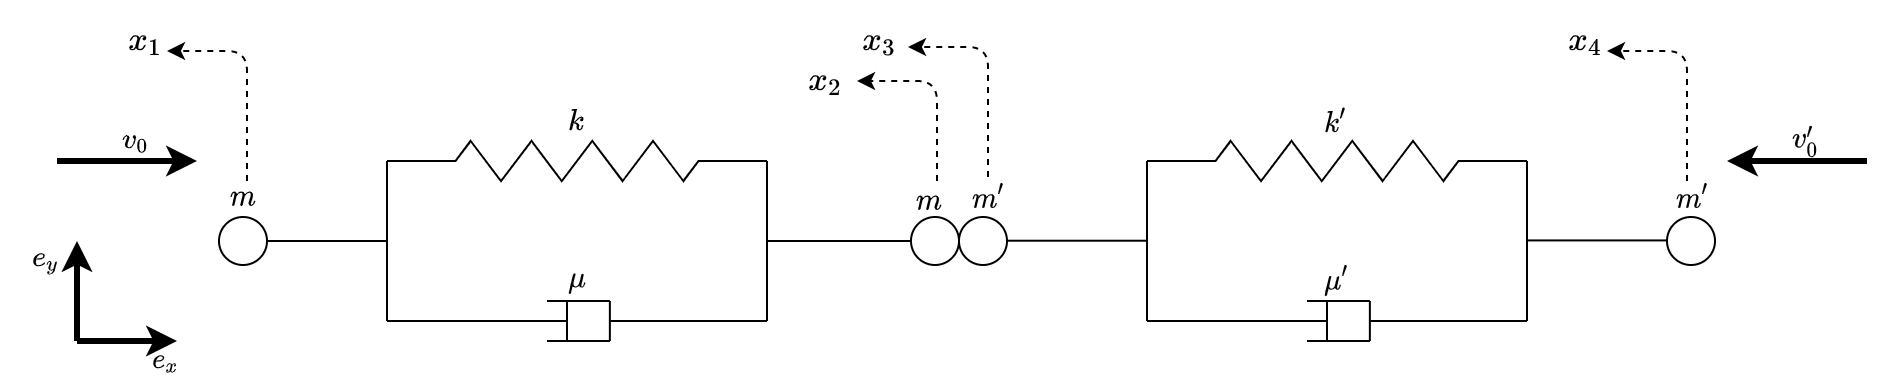

In [20]:
Image("../../reports/internship/Figures/Percussion1D-Systeme-3.png")

In [21]:
## Problem constants
m = 1.0     ## masse du premier floe
m_ = 1.0    ## masse du deuxième floe

k = 15     ## raideurs
k_ = 30

mu = 1.9    ## viscosités
mu_ = 1.1

v0 = 1.8    ## vitesses avant le choc
v_0 = 2.5

eps = 0.4   ## coefficient de restitution

In [22]:
## Geometric constants
L = 20.0
H = 1.5

L0 = L/10.0     # Spring 1 length at rest
L_0 = L/8.0     # Spring 2 length at rest

R = H/6.0      # Radius for the balls at the end of the springs

z0 = 0.0
z_0 = L-L_0

In [23]:
""" Définitions des temps de simulation  """
N=2000
t_contact=1.0          # temps de contact

## Avant le contact
tmax1 = ((z_0-R) - (z0 + L0+R)) / (v0 + v_0)       ## Calculer tmax a la main pour correspondre au moment du contact
t = np.linspace(0, tmax1, N+1)
t_old = t
dt = tmax1 / N

## Apres le contact
tmax2 = 4*tmax1
N2 = 3*N
t_new = np.linspace(0, tmax2, N2+1)

In [24]:
## Positions of the first ice-floe before collision
def uniform_mouvement_1(y,t):
    return v0
z = odeint(uniform_mouvement_1, z0, t)[:,0]

## Positions of the second ice-floe before collision
def uniform_mouvement_2(y,t):
    return -v_0
z_ = odeint(uniform_mouvement_2, z_0, t)[:,0]

In [25]:
# # print(z)
# # print(z_)

## Detection of the collision position
# contactPos = v0*(L-L_0)/(v0+v_0)
# print(contactPos)
# print(-v_0*(L-L_0)/(v0+v_0) + L-L_0)

# newZ = z[z<contactPos]
# print(newZ)

# newZ_ = z_[z_>(contactPos+L0)]
# print(newZ_)
# print(newZ_.size)

In [26]:
## Calculating I necessary for speed after contact
def simulate_displacement(m=1.0, k=18.0, mu=1.3, v0=0.8, v_0=0.8, t_simu=1.0, N=N):
    E = np.array([[0,0,1.0, 0],
                  [0,0,0,1.0],
                  [-k/m, k/m, -mu/m, mu/m],
                  [k/m, -k/m, mu/m, -mu/m]])
    Y0 = np.array([0,0, v0, v_0])
    t = np.linspace(0, t_simu, N+1)

    def model(Y, t):
        return E @ Y
    
    return t, odeint(model, Y0, t)

t_con, X12 = simulate_displacement(m, k, mu, v0, v0, t_contact)
t_con, X34 = simulate_displacement(m_, k_, mu_, -v_0, -v_0, t_contact)
integrand = k*(X12[:,0] - X12[:,1]) + mu*(X12[:,2] - X12[:,3]) -k_*(X34[:,0] - X34[:,1]) - mu_*(X34[:,2] - X34[:,3])

I = np.trapz(y=integrand, x=t_con)
print("Value of I for speeds:", I)
# print(integrand, t_con)
    
## Calculating the speeds after contact
# I = 0.0    ## Needs to be perfected !
V0 = (I + (m + eps*m_)*v0 + (1-eps)*m_*v_0) / (m+m_)
V_0 = (I + (1-eps)*m*v0 + (m_ + eps*m)*v_0) / (m+m_)

print("First floe speeds:", [v0, V0])
print("Second floe speeds:", [V_0, v_0])

Value of I for speeds: 0.0
First floe speeds: [1.8, 2.01]
Second floe speeds: [2.29, 2.5]


8.279069767441861 [8.27906977 8.27441499 8.26979973 ... 6.81444186 6.81419768 6.81395349]
(8002,)


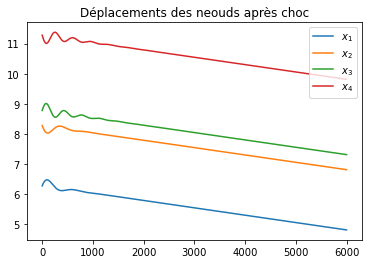

In [27]:
## Positions of the first ice-floe after collision
# print(t)
t = t_new  ## t becomes t after choc
# print(t)

def new_mouvement_1(y, t):
#     return -np.abs(v0 - V0)
    return 0                     ### This is how it should normaly be!
Z = odeint(new_mouvement_1, z[-1], t)[:,0]

## Positions of the second ice-floe after collision
def new_mouvement_2(y, t):
#     return np.abs(V_0 - v_0)
    return 0                    ### This is how it should normaly be!
Z_ = odeint(new_mouvement_2, z_[-1], t)[:,0]

# ## Positions (displacements) of the first floe after collision (x1 c'est normalement x2, et x2 c'est x3!)
# Delta = mu*mu - 2*k*m
# print("Delta:", Delta)
# if Delta > 0:
#     lambda1 = (-mu - np.sqrt(Delta))/m
#     lambda2 = (-mu + np.sqrt(Delta))/m
#     x1 = Z + 0.5*t*(v0 - V0) + (np.exp(t*lambda1) - np.exp(t*lambda2))*(v0 + V0)/(2*(lambda2 - lambda1))
# else:
#     alpha = -mu/m
#     beta = - np.sqrt(-Delta)/m
#     x1 = Z + 0.5*t*(v0 - V0) + np.exp(t*alpha)*np.sin(beta*t)*(v0 + V0)/(2*beta)

# ## Positions (displacements) of the second floe after collision
# Delta_ = mu_*mu_ - 2*k_*m_
# print("Delta_:", Delta_)
# if Delta_ > 0:
#     lambda1 = (-mu_ - np.sqrt(Delta_))/m_
#     lambda2 = (-mu_ + np.sqrt(Delta_))/m_
#     x2 = Z_ + 0.5*t*(V_0 - v_0) - (np.exp(t*lambda1) - np.exp(t*lambda2))*(V_0 + v_0)/(2*(lambda2 - lambda1))
# else:
#     alpha = -mu_/m_
#     beta = - np.sqrt(-Delta_)/m_
#     x2 = Z_ + 0.5*t*(V_0 - v_0) - np.exp(t*alpha)*np.sin(beta*t)*(V_0 + v_0)/(2*beta)


# print(t)

t, X12 = simulate_displacement(m, k, mu, v0, -np.abs(V0), tmax2, N2)
t, X34 = simulate_displacement(m_, k_, mu_, np.abs(V_0), -v_0, tmax2, N2)

x1 = Z - 0 + X12[:,0]
x2 = Z + L0 + X12[:,1]

x3 = Z_ + X34[:,0]
x4 = Z_ + L_0 + X34[:,1]

print(z[-1]+L0, x2)

t = t_old       ## t rebecomes t before choc
t = np.concatenate([t, t_new])
print(t.shape)

## Computing the positions of the other ends (1 for floeA and 4 for floeB)
zz = z
z_z_ = z_

zz = np.concatenate([zz, x1])
z = np.concatenate([z+L0, x2])

z_ = np.concatenate([z_, x3])
z_z_ = np.concatenate([z_z_+L_0, x4])

plt.plot(x1, label=r"$x_1$")
plt.plot(x2, label=r"$x_2$")
plt.plot(x3, label=r"$x_3$")
plt.plot(x4, label=r"$x_4$")
plt.title("Déplacements des neouds après choc")
plt.legend();

In [28]:
## Une fonction pour dessiner un ressort
def plot_spring(x, y, theta, L, H, L0, ax):
    """ Plot the spring from (x,y) with length L and height H as the projection of a helix."""
    # Spring turn radius, number of turns
    rs, ns = 0.05, int(5*L0)
    # Number of data points for the helix
    Ns = 1000
    # We don't draw coils all the way to the end of the spring:
    # pad a bit from the ball to the start of oscillations
    ipad1, ipad2 = 150, 150
    w = np.linspace(0, L, Ns)
    # Set up the helix along the x-axis ...
    xp = np.zeros(Ns)
    xp[ipad1:-ipad2] = rs * np.sin(2*np.pi * ns * w[ipad1:-ipad2] / L)
    # ... then rotate it to align with  the pendulum and plot.
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    xs, ys = - R @ np.vstack((xp, w))
    ax.plot(x+xs, y+(H*ys)/np.max(ys), c='k', lw=2)

## Une fonction pour dessiner un noeud de ressort
def plot_circle(x, y, R, ax):
    # Circle at position (x,y) with radius R
    c = Circle((x, y), R, fc='white', ec='k', lw=2, zorder=10)
    ax.add_patch(c)

## Une fonction pour dessiner un floe de glace (systeme masse-ressort)
def plot_ice_floe(x1,y1, x2,y2, R, L0, ax):
    """ Plot an ice floe whose nodes are at (x1,y1) and (x2,y2) with same radius R """
    plot_circle(x1,y1,R,ax)
    plot_circle(x2,y2,R,ax)
    if x1 > x2:
        tmp = x2
        x2 = x1
        x1 = tmp
    elif x1 == x2:
        print("Carefull: zero sized spring!")

    plot_spring(x1+R/2, 0, np.pi/2.0, x2-x1-R, R/1.2, L0, ax)

In [29]:
# """ Clear the given directory of all PNG files """
# def clear_dir(path):
#     files = glob.glob(path+'/*.png', recursive=True)
#     for f in files:
#         try:
#             os.remove(f)
#         except OSError as e:
#             print("Error: %s : %s" % (f, e.strerror))

In [30]:
def fig2img(fig):
    """ Convert a Matplotlib figure to a PIL Image and return it """
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    img = PILImage.open(buf)
    # img = plt.imread(buf)
    return img


In [31]:
def make_plot(i, path, ax):
    """
    Plot and save an image of the system configuration for time point i.
    """
    # plot_ice_floe(z[i],0, z[i]+L0,0, R, L0, ax)
    # plot_ice_floe(z_[i],0, z_[i]+L_0,0, R, L_0, ax)

    plot_ice_floe(zz[i],0, z[i],0, R, L0, ax)
    plot_ice_floe(z_[i],0, z_z_[i],0, R, L_0, ax)
    
    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(0, L)
    ax.set_ylim(-2*R, 2*R)
    ax.set_aspect('equal', adjustable='box')
    # plt.axis('off')
    # plt.savefig(path+'/_img{:04d}.png'.format(i//di), dpi=72)
    img_list.append(fig2img(fig))
    # Clear the Axes ready for the next image.
    plt.cla();

0 / 140
1 / 140
2 / 140
3 / 140
4 / 140
5 / 140
6 / 140
7 / 140
8 / 140
9 / 140
10 / 140
11 / 140
12 / 140
13 / 140
14 / 140
15 / 140
16 / 140
17 / 140
18 / 140
19 / 140
20 / 140
21 / 140
22 / 140
23 / 140
24 / 140
25 / 140
26 / 140
27 / 140
28 / 140
29 / 140
30 / 140
31 / 140
32 / 140
33 / 140
34 / 140
35 / 140
36 / 140
37 / 140
38 / 140
39 / 140
40 / 140
41 / 140
42 / 140
43 / 140
44 / 140
45 / 140
46 / 140
47 / 140
48 / 140
49 / 140
50 / 140
51 / 140
52 / 140
53 / 140
54 / 140
55 / 140
56 / 140
57 / 140
58 / 140
59 / 140
60 / 140
61 / 140
62 / 140
63 / 140
64 / 140
65 / 140
66 / 140
67 / 140
68 / 140
69 / 140
70 / 140
71 / 140
72 / 140
73 / 140
74 / 140
75 / 140
76 / 140
77 / 140
78 / 140
79 / 140
80 / 140
81 / 140
82 / 140
83 / 140
84 / 140
85 / 140
86 / 140
87 / 140
88 / 140
89 / 140
90 / 140
91 / 140
92 / 140
93 / 140
94 / 140
95 / 140
96 / 140
97 / 140
98 / 140
99 / 140
100 / 140
101 / 140
102 / 140
103 / 140
104 / 140
105 / 140
106 / 140
107 / 140
108 / 140
109 / 140
110 / 140


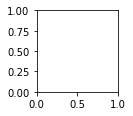

In [32]:
"""
# Make an image every di time points, corresponding to a frame rate of fps
"""
path = "frames"
fps = 10
di = int(1/fps/dt)
# This figure size (inches) and dpi give an image of .
fig = plt.figure(figsize=(L, H), dpi=72)
ax = fig.add_subplot(111)

# clear_dir(path)
img_list = []

for i in range(0, t.size, di):
    print(i // di, '/', t.size // di)
    make_plot(i, path, ax);

In [33]:
# imageio.mimwrite('Animation1D.gif', image_list, loop=3, duration=total_duration/nb_frames)
imageio.mimwrite('Animation1D.gif', img_list)

In [34]:
# Image("Animation1D.gif")
os.system('eog Animation1D.gif')     ## Only on Linux GNOME


1